In [134]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [185]:
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [256]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "global_average_pooling2d_9",
    "dense_9",
]


In [192]:
last_conv_layer = model.layers[-4].get_layer('block14_sepconv2_act')
last_conv_layer_model = keras.Model(model.layers[-4].inputs, last_conv_layer.output)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_10:0


In [195]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098

In [202]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [257]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
#     last_conv_layer = model.get_layer(last_conv_layer_name)
#     last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    last_conv_layer = model.layers[-4].get_layer('block14_sepconv2_act')
    last_conv_layer_model = keras.Model(model.layers[-4].inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [285]:
(data_dir/"Corona*").as_posix()

'data/covid_data/Corona*'

In [286]:
import glob
for files in glob.glob((data_dir/"Corona*").as_posix()):
    print(files)

data/covid_data/Corona1_63.jpg
data/covid_data/Corona2_9.jpg
data/covid_data/Corona1_67.jpg
data/covid_data/Corona1_29.jpg
data/covid_data/Corona1_40.jpg
data/covid_data/Corona2_1.jpg
data/covid_data/Corona1_80.jpg
data/covid_data/Corona2_6.jpg
data/covid_data/Corona1_21.jpg
data/covid_data/Corona1_30.jpg
data/covid_data/Corona1_68.jpg
data/covid_data/Corona1_39.jpg
data/covid_data/Corona1_66.jpg
data/covid_data/Corona1_11.jpg
data/covid_data/Corona1_17.jpg
data/covid_data/Corona1_28.jpg
data/covid_data/Corona1_61.jpg
data/covid_data/Corona2_35.jpg
data/covid_data/Corona1_26.jpg
data/covid_data/Corona1_41.jpg
data/covid_data/Corona1_72.jpg
data/covid_data/Corona2_31.jpg
data/covid_data/Corona1_9.jpg
data/covid_data/Corona3_9.jpg
data/covid_data/Corona2_33.jpg
data/covid_data/Corona2_34.jpg
data/covid_data/Corona1_25.jpg
data/covid_data/Corona2_15.jpg
data/covid_data/Corona2_21.jpg
data/covid_data/Corona3_8.jpg
data/covid_data/Corona3_4.jpg
data/covid_data/Corona1_77.jpg
data/covid_data

In [294]:
# Prepare image
for img_path in glob.glob((data_dir/"Non_Corona*").as_posix()):
    #img_path = data_dir/"Corona3_8.jpg"
    img_array = preprocess_input(get_img_array(img_path, size=img_size))

    # Make model
    #model = model_builder(weights="imagenet")

    # Print what the top predicted class is
    preds = model.predict(img_array)
    #print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names
    )

    # Display heatmap
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    save_path = f"./data/cam/{img_path.split('/')[-1]}"
    superimposed_img.save(save_path)
    

In [290]:
files.split("/")[-1]

'Corona2_25.jpg'

In [277]:
# Prepare image
img_path = data_dir/"Corona3_8.jpg"
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [278]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

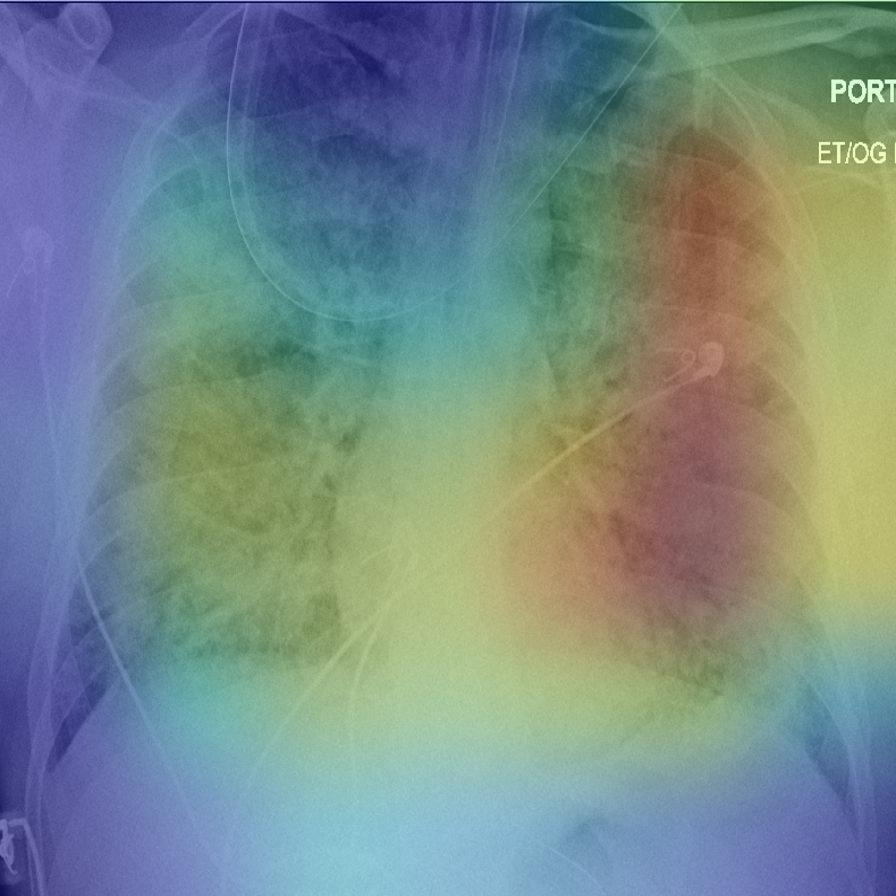

In [279]:
# Save the superimposed image
save_path = "./Corona3_8_cam.jpg"
superimposed_img.save(save_path)
Image(save_path)
# Display Grad CAM
#display(Image(save_path))

In [253]:
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 409

In [198]:
from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

import numpy as np
import os
paths = ["Corona1_1.jpg","Corona1_2.jpg","Corona1_20.jpg",]
for path in paths:
    path = os.path.join(data_dir ,path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    #gateFactor = layers.Input(tensor = K.variable([0.3]))
    last_conv_layer = model.layers[-4].get_layer('block14_sepconv2_act')
    last_conv_layer_model = keras.Model(model.layers[-4].inputs, last_conv_layer.output)
    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)
    #heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_10:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_10:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_10:0


In [199]:
heatmap

array([[0.0344332 , 0.08167666, 0.05965023, 0.09298833, 0.1357701 ,
        0.12113214, 0.06600368],
       [0.02424136, 0.11993191, 0.07323105, 0.12638788, 0.19902976,
        0.20255707, 0.10021621],
       [0.02401717, 0.13204147, 0.0785437 , 0.15960933, 0.26589292,
        0.27503362, 0.15522258],
       [0.06799407, 0.29725963, 0.22635473, 0.33896974, 0.43423843,
        0.42343765, 0.2447353 ],
       [0.21624146, 0.61550045, 0.5995282 , 0.77572125, 0.88016886,
        0.8619149 , 0.5070839 ],
       [0.5027279 , 0.9378706 , 0.9748021 , 0.98240536, 1.        ,
        0.956241  , 0.56001514],
       [0.446394  , 0.60804266, 0.6932151 , 0.7033297 , 0.7366464 ,
        0.72186697, 0.5419586 ]], dtype=float32)

In [ ]:
import cv2

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

In [3]:
import os
from pathlib import Path

os.getcwd()

'/home/abhijitgupta/Documents/shk_covid_pytorch-master'

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
import os
import pathlib

import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [6]:
tf.__version__

'2.2.0'

In [7]:
data_dir = "./data/covid_data/"
data_dir = pathlib.Path(data_dir)

In [8]:
list_ds = tf.data.Dataset.list_files(str(data_dir / "*.jpg"))

In [9]:
image_count = len(list(data_dir.glob("*.jpg")))
image_count

280

In [10]:
for f in list_ds.take(5):
    print(f.numpy())

b'data/covid_data/Corona1_40.jpg'
b'data/covid_data/Corona1_21.jpg'
b'data/covid_data/Corona1_13.jpg'
b'data/covid_data/Non_Corona1_60.jpg'
b'data/covid_data/Corona1_48.jpg'


In [11]:
CLASS_NAMES = np.array(["Non_Corona", "Corona"])

In [12]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    x = tf.strings.regex_replace(parts[-1], "\d.*", "")
    return x == np.array(["Non_Corona", "Corona"])

In [13]:
tf.strings.split(b"data/covid_data/Non_Corona1_9.jpg", os.path.sep).numpy()

array([b'data', b'covid_data', b'Non_Corona1_9.jpg'], dtype=object)

In [14]:
get_label(b"data/covid_data/Non_Corona1_77.jpg")

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>

In [15]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [16]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [17]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [18]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
labeled_ds

<ParallelMapDataset shapes: ((224, 224, 3), (2,)), types: (tf.float32, tf.bool)>

In [20]:
for image, label in labeled_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]
Image shape:  (224, 224, 3)
Label:  [ True False]
Image shape:  (224, 224, 3)
Label:  [False  True]
Image shape:  (224, 224, 3)
Label:  [False  True]
Image shape:  (224, 224, 3)
Label:  [ True False]


In [22]:
# steps per epoch = train_length // batch_size
280 * 0.8 // 32
# if augmenting, multiply by 2 or 3

7.0

In [23]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [27]:
split = 3

dataset_train = labeled_ds.window(split, split + 1).flat_map(
    lambda *ds: tf.data.Dataset.zip(ds)
)
# [0, 1, 2, 4, 5, 6, 8, 9]
dataset_validation = (
    labeled_ds.skip(split)
    .window(1, split + 1)
    .flat_map(lambda *ds: tf.data.Dataset.zip(ds))
)
# [3, 7]

Cause: could not parse the source code:

    .flat_map(lambda *ds: tf.data.Dataset.zip(ds))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code:

    .flat_map(lambda *ds: tf.data.Dataset.zip(ds))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [28]:
import numpy as np
import tensorflow_addons as tfa
from tensorflow import keras

In [29]:
import imgaug.augmenters as iaa

seq = iaa.Sequential(
    [
        iaa.Fliplr(0.2),  # horizontal flips
        iaa.Crop(percent=(0, 0.1)),  # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        # iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        # iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-15, 15),
            shear=(-8, 8),
        ),
    ],
    random_order=True,
)  # apply augmenters in random order


def augment_batch(image):
    def augment_image(image):
        return seq.augment(images=image.numpy())

    image = tf.cast(image, tf.float32)
    image = tf.py_function(augment_image, [image], tf.float32)
    return image


# Create a dataset and apply the augmentation.
image = tf.random.uniform((2, 256, 256, 3), minval=0, maxval=100, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((image))
dataset = dataset.batch(32)
dataset = dataset.map(augment_batch)

for record in dataset:
    break

In [30]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [31]:
train_batches = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.map(lambda *ds: (augment_batch(ds[0]), ds[1]))

In [32]:
validation_batches = dataset_validation.batch(BATCH_SIZE).repeat()

In [33]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(16, 16))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        # ax.imshow((img ))
        ax.imshow((img * 255).numpy().astype("uint8"))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [34]:
sample_training_images, _ = next(iter(train_batches.take(1)))

In [35]:
plt.close()
plotImages(sample_training_images[:5])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Raw-Feature Extraction

In [238]:
METRICS = [
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc"),
]

## Train

In [243]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_auc", verbose=1, patience=10, mode="max", restore_best_weights=True
)

## Fine Tuning

In [245]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [246]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 409

In [247]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

epochs = 20
model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    steps_per_epoch=21,
    validation_steps=validation_steps,
)

Epoch 1/20
21/21 [==============================] - 5s 255ms/step - loss: 0.7012 - tp: 304.0000 - fp: 390.0000 - tn: 304.0000 - fn: 390.0000 - accuracy: 0.4380 - precision: 0.4380 - recall: 0.4380 - auc: 0.4092 - val_loss: 0.6996 - val_tp: 30.0000 - val_fp: 34.0000 - val_tn: 30.0000 - val_fn: 34.0000 - val_accuracy: 0.4688 - val_precision: 0.4688 - val_recall: 0.4688 - val_auc: 0.3496
Epoch 2/20
21/21 [==============================] - 4s 211ms/step - loss: 0.6890 - tp: 331.0000 - fp: 299.0000 - tn: 331.0000 - fn: 299.0000 - accuracy: 0.5254 - precision: 0.5254 - recall: 0.5254 - auc: 0.5535 - val_loss: 0.6907 - val_tp: 36.0000 - val_fp: 28.0000 - val_tn: 36.0000 - val_fn: 28.0000 - val_accuracy: 0.5625 - val_precision: 0.5625 - val_recall: 0.5625 - val_auc: 0.5254
Epoch 3/20
21/21 [==============================] - 4s 212ms/step - loss: 0.6830 - tp: 367.0000 - fp: 263.0000 - tn: 367.0000 - fn: 263.0000 - accuracy: 0.5825 - precision: 0.5825 - recall: 0.5825 - auc: 0.5954 - val_loss: 0

In [248]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=METRICS,
)

epochs = 10
history = model.fit(
    train_batches,
    epochs=epochs,
    validation_data=validation_batches,
    steps_per_epoch=21,
    validation_steps=validation_steps,
    callbacks=early_stopping,
)

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_3 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 409

## GRAD CAM++

In [142]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 224, 224, 3)       7         
_________________________________________________________________
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098

In [249]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
#model = create_model()

# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
#loss,acc = model.evaluate(test_images,  test_labels, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [76]:
from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

import numpy as np
import os

In [78]:
predictions

array([[0.17938787, 0.82061213]], dtype=float32)

In [109]:
paths = ["Corona1_1.jpg","Corona1_2.jpg","Corona1_20.jpg",]
for path in paths:
    path = os.path.join(data_dir ,path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = model.predict(img)
#     top_n = 2
#     top = decode_predictions(predictions, top=top_n)[0]
    cls = np.argsort(predictions[0])[-2:][::-1]
    
    gradcam=grad_cam(model,img,layer_name='block14_sepconv2_bn', Xception=True)
    #gradcamplus=grad_cam_plus(model,img,layer_name='block14_sepconv2_bn', Xception=True)
    print(path)
    print("class activation map for:",top[0])
    fig, ax = plt.subplots(nrows=1,ncols=3)
    plt.subplot(131)
    plt.imshow(orig_img)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM")
    plt.subplot(133)
    plt.imshow(orig_img)
    plt.imshow(gradcamplus,alpha=0.8,cmap="jet")
    plt.title("Grad-CAM++")
    plt.show()

LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)

In [ ]:
display()

In [201]:
print(path)
#print("class activation map for:",top[0])
fig, ax = plt.subplots(nrows=1,ncols=3)
plt.subplot(131)
plt.imshow(orig_img)
plt.title("input image")
plt.subplot(132)
plt.imshow(orig_img)
plt.imshow(heatmap,alpha=0.8,cmap="jet")
plt.title("Grad-CAM")
plt.subplot(133)
plt.imshow(orig_img)
plt.imshow(heatmap,alpha=0.8,cmap="jet")
plt.title("Grad-CAM++")
plt.show()

data/covid_data/Corona1_20.jpg


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [86]:
model.layers[-4].get_layer("block14_sepconv2_bn")

In [99]:
img.shape

(1, 224, 224, 3)

In [101]:
model

In [107]:
predictions

array([[1.2644168e-16, 1.0000000e+00]], dtype=float32)

In [ ]:
from functools import partial

import jax.numpy as np
from jax import grad, jacfwd, jacrev, jit, pmap, random, vmap

key = random.PRNGKey(0)

In [ ]:
def sigmoid(x):
    return 0.5 * (np.tanh(x / 2) + 1)


# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(np.dot(inputs, W) + b)

In [ ]:
# Build a toy dataset.
inputs = np.array(
    [[0.52, 1.12, 0.77], [0.88, -1.08, 0.15], [0.52, 0.06, -1.30], [0.74, -2.49, 1.39]]
)
targets = np.array([True, True, False, True])

In [ ]:
# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)  # likelihood
    return -np.sum(np.log(label_probs))

In [ ]:
# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [ ]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print("W_grad", W_grad)

In [ ]:
b_grad = grad(loss, argnums=1)(W, b)
print("b_grad", b_grad)

In [ ]:
# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print("W_grad", W_grad)
print("b_grad", b_grad)

In [ ]:
def loss2(param_dict):
    preds = predict(param_dict["W"], param_dict["b"], inputs)
    probs = preds * targets + (1 - preds) * (1 - targets)
    return -np.sum(np.log(probs))

In [ ]:
print(grad(loss2)({"W": W, "b": b}))

## Custom Containers

In [ ]:
from collections import namedtuple

Point = namedtuple("Point", ["x", "y"])

In [ ]:
pt = Point(1.0, 2.0)
pt

In [ ]:
from jax.tree_util import register_pytree_node

register_pytree_node(
    Point, lambda xs: (tuple(xs), None), lambda _, xs: Point(*xs),
)

In [ ]:
(lambda xs: (tuple(xs), None))(pt)

In [ ]:
(lambda _, xs: Point(*xs))(None, (1.0, 2.0))

In [ ]:
def f(pt):
    return np.sqrt(pt.x ** 2 + pt.y ** 2)

In [ ]:
print(f(pt))
print(grad(f)(pt))
g = jit(f)
print(g(pt))